## Do women ask more questions at a seminar if a woman asks the 1st question?

Prompted by a tweet from Duncan Green referring to a post on his blog:
http://oxfamblogs.org/fp2p/how-to-stop-men-asking-all-the-questions-in-seminars-its-really-easy/

Original source for data:
"Women’s visibility in academic seminars: women ask fewer questions than
men," Alecia Carter, Alyssa Croft, Dieter Lukas, Gillian Sandstrom

RTB wrote it, 14 December 2017. RTB revised for TAD answers, original name was sexQuestionDemo.m. Translated to Python by RTB and EB August 2021. JP added vectorized approach Jun 2022.

Concepts covered:
1. histograms for summarizing data
2. difference between 'sig' and 'not sig' is not itself nec. stat. sig.
3. d-prime as a measure of effect size
4. simulating data under H0
5. detecting and removing sorting biases
6. extracting p-values from simulations

## Set up the environment


In [2]:
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
sns.set(style = 'white', font_scale = 1.2)
print("Setup Complete")

Setup Complete


## Load data

Each datum represents a value derived from one academic seminar. Values
are percentage of questions from women minus the percentage of seminar
attendees who were women. Positive values indicate that women asked more
questions; negative values indicate that men asked more questions. 

We have our data in a pandas dataframe `data`. We will use tidy data so each row is a seminar and we have two columns. The first column contains the percentage difference values discussed above, and the second represents whether a man or woman asked the first question. Note that we don't see that many benefits from using pandas with just two columns and the analyses we do here, but we will use it to familiarize ourselves with using pandas.

NOTE: I reverse-engineered the raw data based on the graphic in the piece
by The Economist, so the numbers might not be exactly correct

In [3]:
woman_first = np.array([60,44,36,36,28,28,28,28,28,24,20,16,16,12,8,8,8,8,8,8,8,8,4,4,4,4,4,4,0,0,0,0,0,0,0,-4,-4,-4,-4,-4,-4,-8,-8,-8,-8,-8,-12,-12,-12,-12,-12,-12,-12,-12,-12,-16,-16,-16,-16,-16,-16,-16,-16,-16,-20,-20,-20,-20,-20,-20,-20,-20,-24,-24,-28,-32,-36,-40])

man_first = np.array([24,24,20,20,16,16,16,16,16,16,16,12,8,4,4,4,0,0,0,0,0,-4,-4,-4,-4,-4,-4,-4,-4,-4,-8,-8,-8,-8,-8,-8,-12,-12,-12,-12,-12,-12,-12,-12,-12,-12,-12,-12,-12,-12,-12,-16,-16,-16,-16,-20,-20,-20,-20,-20,-20,-20,-24,-24,-24,-24,-24,-24,-24,-24,-24,-24,-24,-24,-24,-24,-24,-24,-24,-24,-24,-24,-24,-24,-28,-28,-28,-28,-28,-28,-28,-28,-28,-32,-32,-32,-32,-32,-32,-32,-32,-32,-32,-36,-36,-36,-36,-36,-36,-36,-36,-36,-36,-40,-40,-40,-40,-40,-40,-40,-40,-40,-40,-40,-44,-44,-44,-44,-44,-44,-44,-44,-44,-44,-44,-44,-48,-48,-48,-48,-48,-48,-48,-48,-52,-52,-52,-52,-52,-52,-52,-56,-56,-56,-56,-56,-56,-56,-56,-60,-60,-60,-60,-64,-64,-64,-64,-68,-72,-72,-76]).astype('int')

percentage_questions = np.concatenate((woman_first, man_first))
gender_indicators = np.concatenate([np.repeat(0, len(woman_first)), np.repeat(1, len(man_first))])

# Create a matrix to hold all the data
data = np.array([percentage_questions, gender_indicators]).T

# Create some variables so we don't have to remember what was where
percentage_col = 0
gender_col = 1
WOMAN = 0
MAN = 1

# Show top 5 rows of data
data[:5, :]

array([[60,  0],
       [44,  0],
       [36,  0],
       [36,  0],
       [28,  0]])

In [4]:
# Report number of seminars with woman first vs man first
print(f'Men first: {np.sum(data[:, gender_col] == MAN)}')
print(f'Woman first: {np.sum(data[:, gender_col] == WOMAN)}')

Men first: 171
Woman first: 78


To get data for the seminars where a woman asked the first question, you could do:

In [5]:
woman_rows_bool = data[:, gender_col]==WOMAN
woman_first_mat = data[woman_rows_bool, :]
woman_first_mat[:5, :]

array([[60,  0],
       [44,  0],
       [36,  0],
       [36,  0],
       [28,  0]])

And similarly, for men:

In [6]:
man_first_mat = data[data[:,gender_col]==MAN, :]  # note that we can actually nest the indexing expression like this -- no need for two separate lines. But of course, it's harder to understand this way.
man_first_mat[:5, :]

array([[24,  1],
       [24,  1],
       [20,  1],
       [20,  1],
       [16,  1]])

And you can get summary statistics:

In [7]:
woman_first_mat[:, percentage_col].mean(), man_first_mat[:, percentage_col].mean()

(-2.1538461538461537, -27.157894736842106)

Of course, we could've just used the raw data...

In [8]:
woman_first.mean(), man_first.mean()

(-2.1538461538461537, -27.157894736842106)

... but usually the "raw" data will come in matrix form, so it's good practice to work with that format.

## Plot data

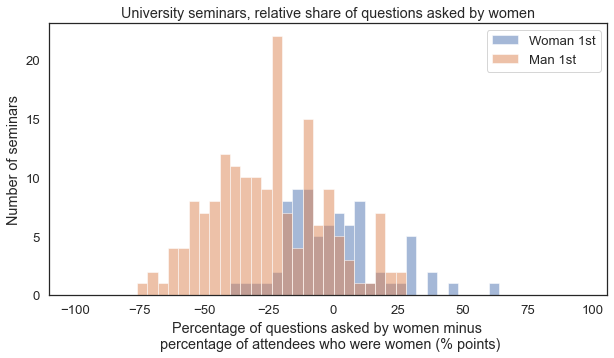

In [9]:
# Plot histogram of data
plt.figure(figsize=(10,5))
bins = np.arange(-100,100,4)

plt.hist(woman_first, bins=bins, alpha=0.5, label='Woman 1st')
plt.hist(man_first, bins=bins, alpha=0.5, label='Man 1st')

plt.xlabel('Percentage of questions asked by women minus \n percentage of attendees who were women (% points)')
plt.ylabel('Number of seminars')
plt.title('University seminars, relative share of questions asked by women')

plt.legend()

## Check for equal variances
Many of the statistical tests that we'll perform on distributions (in this case, t-tests) assume that the underlying populations have the same variance. We can test for this by comparing the sample variances with an F-test -- essentially testing how close the ratio of the sample variances is to 1.

In [10]:
# Compute F statistic
F = np.var(woman_first_mat[:,percentage_col], ddof=1) / np.var(man_first_mat[:,percentage_col], ddof=1)

# Get number of data points
n_woman_first = woman_first_mat.shape[0]
n_man_first = man_first_mat.shape[0]

# Compute p value
p_value = 2 * min([stats.f.cdf(F, n_woman_first - 1 , n_man_first - 1), 1 - stats.f.cdf(F, n_woman_first - 1 , n_man_first - 1)])

print(f'The p-value is {p_value:.4f}')

The p-value is 0.1123


We fail to reject H0 of equal variances, so we can proceed as if they are equal.


https://en.wikipedia.org/wiki/Sensitivity_index

## Do women tend to ask more questions when a woman asks the first question?

NOTE: Here is the original tweet from Duncan Green:
In academic seminars, ‘Men are > 2.5 times more likely to pose questions to the speakers. This male skew was observable only in those seminars in which a man asked first question. When a woman did so, gender split disappeared’. CHAIRS PLEASE NOTE – FIRST Q TO A WOMAN – EVERY TIME.’

It was based on this story he had read in The Economist (https://www.economist.com/news/science-and-technology/21732082-there-easy-fix-women-ask-fewer-questions-men-seminars)
Print edition | Science and technology
December 7, 2017

"ONE theory to explain the low share of women in senior academic jobs is that they have less self-confidence than men. This hypothesis is supported by data in a new working paper, by a team of researchers from five universities in America and Europe. In this study, observers counted the attendees, and the questions they asked, at 247 departmental talks and seminars in biology, psychology and philosophy that took place at 35 universities in ten countries. On average, half of each seminar’s audience was female. Men, however, were over 2.5 times more likely to pose questions to the speakers—an action that may be viewed (rightly or wrongly) as a sign of greater competence.

This male skew in question-asking was observable, however, only in those seminars in which a man asked the first question. When a woman did so, the gender split in question-asking was, on average, proportional to that of the audience. Simply handing the microphone to a woman rather than a man when the floor is opened for questions may make a difference, however small, to one of academia’s most intractable problems."

This is a classic example of the fallacy that Gelman & Stern write about: The Difference Between “Significant” and “Not Significant” is not Itself Statistically Significant

In other words, what the blogger did was two t-tests, one of which showed that the man-first data are highly statistically significant from 0. That is, men ask significantly more questions when a man asks the 1st Q.

In [11]:
_, p_man_first = stats.ttest_1samp(man_first, popmean = 0)
print(f'The p-value of the test using data from man first seminars is {p_man_first:.2e}')

_, p_woman_first = stats.ttest_1samp(woman_first, popmean = 0)
print(f'The p-value of the test using data from woman first seminars is {p_woman_first:.2f}')

The p-value of the test using data from man first seminars is 3.56e-36
The p-value of the test using data from woman first seminars is 0.31


But this does not necessarily mean that the two groups are significantly different FROM EACH OTHER. This is very common statistical error that is beautifully described in a classic paper:

Gelman A & Stern H (2006) "The Difference Between 'Significant' and 'Not Significant' is not Itself Statistically Significant", The American Statistician (2006) 60:328-331

To establish a difference between the two groups, you need to directly compare them. A simple way is with a 2-sample t-test:

In [12]:
t_statistic_two_sample, p_two_sample = stats.ttest_ind(woman_first, man_first)

print(f'The t-statistic of the 2 sample test is {t_statistic_two_sample:.2f}')
print(f'The p-value of the 2 sample test is {p_two_sample:.2e}')

The t-statistic of the 2 sample test is 8.71
The p-value of the 2 sample test is 4.59e-16


Note that the t-statistic is also a kind of
effect size. It is normalized by a pooled estimate of the s.e.m., so it
will be larger than our d-prime, which is normalized by the pooled
estimate of the s.d.

Or, if we suspect the data are not normally distributed, we can use a
non-parametric test based on the ranks of the data. This is known as the
Wilcoxon Rank-Sum Test (equivalent to the Mann-Whitney U Test).


In [13]:
stats.ranksums(woman_first, man_first)

RanksumsResult(statistic=7.793966835209147, pvalue=6.493759792763967e-15)

In any case, there does appear to be a very real effect of who asks the
first question. So the conclusion is correct, even though it was
originally based on a faulty comparison.


## Bias produced by the way the data were sorted?
Note that there is a possible source of bias in the way the data
have been stratified (a fancy statistical word for "sorted"). If there are a relatively small number of questions asked at any given seminar, then when you divide the data into two subsets where the sex of the 1st question asker is fixed, you create a bias in that direction. We can simlulate this to see how big the bias effect is.

**Keys to the simulation (answer these before you write any code!)** 

Under what hypothesis should we perform our simulation? 

What is H0?

(In what follows, we make the simplifying assumption that all seminars have the same number of questions. See the next section for relaxing this assumption.)

******

This is a helper function to plot our simulation results, used later.

In [82]:
def plot_simulation_results(all_effect_sizes, real_effect_size, num_seminars, num_q_per_seminar, num_sims, alpha=0.05):
    
    # Plot results
    plt.hist(all_effect_sizes, bins=np.arange(all_effect_sizes.min(), all_effect_sizes.max(), 0.5))
    
    # Draw a solid black line for the actual effect size
    plt.vlines(real_effect_size, 0, plt.ylim()[1], 'k')
    
    # Label plot
    plt.xlabel('Effect size due to sorting bias')
    plt.ylabel('# of simulations')
    plt.title(f'# of seminars: {num_seminars}, Questions per seminar: {num_q_per_seminar}')
    
    # Plot CIs
    idx_hi = np.ceil(num_sims * (1 - alpha / 2)).astype('int')
    idx_lo = np.floor(num_sims * (alpha / 2)).astype('int')
    sorted_effect_sizes = np.sort(all_effect_sizes)
    sim_CI = [sorted_effect_sizes[idx_lo], sorted_effect_sizes[idx_hi]]
    plt.vlines(sim_CI, 0, plt.ylim()[1], colors='b', linestyles='--')
    
    # One-tailed p-value
    p_value_1 = np.sum(all_effect_sizes >= real_effect_size) / num_sims

    # Why do I do this? Can a p-value ever be 0?
    if p_value_1 == 0:
        p_value_1 = 1 / (num_sims + 1)

    # Print p-value on plot
    plt.annotate(f'p = {p_value_1:.4f}', (.2, .8), xycoords = 'figure fraction')
    

NB: below, we will set the random number generator seed to 12. This ensures that we will all get the exact same answer (provided we run the simulation the same number of times). You would ordinarily NOT do this. Why?

In [ ]:
# Set random seed
np.random.seed(12)

# Simulation parameters
num_q_per_seminar = 6
num_seminars = 249
num_simulations = int(1e4)
fix_bias = False

# Variables to hold the results of our simulations
all_effect_sizes = np.zeros((num_simulations,))
all_d_primes = np.zeros((num_simulations,))

# TODO: simulate the experiment num_simulations times!
for iSim in range(num_simulations):

    # Generate data for each simulated seminar
    ...
        
    # Collect the statistics of interest (ie who asked first question, and how many questions women asked)
    ...

    # Calculate and store the effect size for this simulation
    all_effect_sizes[iSim] = ...
    
# Plot the results
plot_simulation_results(all_effect_sizes, 25, num_seminars, num_q_per_seminar, num_simulations)


**QUESTION (Q1)**: What is the effect size the authors actually obtained?

@clarify: effect size is ambiguous, is there a specific term for diff of means without normalizing?

In [15]:
# Calculate the effect size the authors actually obtained
real_effect_size = ...

print(real_effect_size)

Ellipsis



**QUESTION (Q2)**: What is the mean effect size, rounded to the nearest whole
number, if there are only 3 questions asked at each seminar?


**QUESTION (Q3)**: What if there are 4 questions per seminar?


**QUESTION (Q4)**: What if there are 5 questions per seminar?


**QUESTION (Q5)**: Do you see a trend? Try smaller values for `num_q_per_seminar` and
think about what is going on.


**QUESTION (Q6)**: So then why do the simulation? What does it add?


**QUESTION (Q7)**: What would happen to our distribution of simulated effect sizes if there
were 127 seminars instead of 249? Simulate it and compare!


**QUESTION (Q8)**: What is the smallest number of questions per seminar for
which you would be 95% confident that the actual effect size obtained
(25) was not purely do to a sorting bias? Hint: For a given `num_q_per_seminar`,
look at the distribution of your simulated values, and see where the
actual effect size obtained falls within this distribution.


**QUESTION (Q9)**: How could you eliminate this bias?


## Bonus: Variable number of questions per seminar

Let's suppose we don't want to assume that there were the exact same
number of questions asked at each seminar. How could we build this into
our simulation?

Maybe we just know that, on average, there were m questions per seminar.
Since we can assume that seminars have no memory (i.e. for how many
questions were asked at the previous seminars), we can just draw values
from a Poisson distribution with lambda set to the mean number of
questions over all seminars. That is, for each round of our simulation, use 'np.random.poisson' to generate the number of questions at each seminar, and then proceed as before. Your code will likely be a little bit more complicated, but the principle is the same.

In [88]:
# Set random seed
np.random.seed(12)

# Simulation parameters
num_q_per_seminar = 6
num_seminars = 249
num_simulations = int(1e4)
fix_bias = False

# Variables to hold the results of our simulations
all_effect_sizes = np.zeros((num_simulations,))

# Loop over simulations
for iSim in range(num_simulations):

    # Generate data for each simulated seminar
    ...
        
    # Collect the statistics of interest (ie who asked first question, and how many questions women asked)
    ...

    # Calculate and store the effect size for this simulation
    all_effect_sizes[iSim] = ...
    
# Plot the results
plot_simulation_results(all_effect_sizes, 25, num_seminars, num_q_per_seminar, num_simulations)


This seems to have a very profound effect on our simulation. Did we make
a mistake? To start to get some insight into this question, let's look at
the distribution of the actual number of questions asked

In [16]:
# TODO: plot a histogram showing number of questions asked at each seminar from the simulation.
# (If you didn't save those data, go back and re-run your simulation with an array to save them!)

Recall the formula we derived for the mean bias as a function of the number of questions asked per seminar:

`mean_bias_effect = 100 / num_q_per_seminar`

Does this account for the increase in bias in this simulation? Why?